In [2]:
# set up enviroment
from __future__ import division
import sys
import numpy as np
import pandas as pd 
import scipy
import importlib
import scanpy as sc

import hdbscan
import scanpy as sc
from harmony import harmonize


from sklearn.manifold import TSNE
import sklearn

sys.path.append("../resources/")
import sct

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi_save=600)

scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [4]:
adata = sc.read_h5ad('../data/adata_all_panPN_annotated_final.h5ad')
df_libs = pd.read_csv("../data/libs.csv", sep="\t", header=0, index_col=0) # sample info

In [6]:
genes_24h_ICIM = []
with open("../data/ICIM_genes/24h_ICIM_561.txt") as f:
    for line in f:
        genes_24h_ICIM.append(line.rstrip())
print("Total ICIM genes at 24h= ", len(genes_24h_ICIM))

Total ICIM genes at 24h=  561


# 24h

In [7]:
adata_24h = adata[(adata.obs['genotype'] == 'GH146-GFP') & (adata.obs['stage'] == '24h')]
adata_24h

View of AnnData object with n_obs × n_vars = 946 × 17474 
    obs: 'batch', 'genotype', 'stage', 'n_counts', 'n_genes', 'PN_type', 'MARS', 'HDBSCAN', 'MARS_2way_matched', 'MARS_2way_matched_PN_type', 'lineage', '24h_HDBSCAN', 'matched_type_with_stage', 'mannually_matched'
    var: 'highly_variable'
    uns: '24h_HDBSCAN_colors', 'HDBSCAN_colors', 'MARS_2way_matched_PN_type_colors', 'MARS_2way_matched_colors', 'MARS_colors', 'PN_type_colors', 'mannually_matched_colors', 'stage_colors'
    obsm: 'X_tsne'

24h ICIM genes

In [8]:
adata_24h.var['highly_variable'] = adata_24h.var_names.isin(genes_24h_ICIM)

Trying to set attribute `.var` of view, copying.


In [9]:
df_ICIM = adata_24h.to_df()[genes_24h_ICIM].T
myTSNE = sct.TSNE(df_ICIM, adata_24h.to_df().T, df_libs)
myTSNE.calc_TSNE(perplexity=10, learning_rate=250, early_exaggeration=4.0, method="exact", random_state=1)

[t-SNE] Computed conditional probabilities for sample 946 / 946
[t-SNE] Mean sigma: 0.131457
[t-SNE] Iteration 50: error = 14.6801399, gradient norm = 0.0840154 (50 iterations in 1.663s)
[t-SNE] Iteration 100: error = 13.6372826, gradient norm = 0.0773147 (50 iterations in 1.707s)
[t-SNE] Iteration 150: error = 13.4073514, gradient norm = 0.0672617 (50 iterations in 1.681s)
[t-SNE] Iteration 200: error = 13.0304119, gradient norm = 0.0660681 (50 iterations in 1.669s)
[t-SNE] Iteration 250: error = 12.9651969, gradient norm = 0.0599808 (50 iterations in 1.710s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 12.965197
[t-SNE] Iteration 300: error = 1.1571104, gradient norm = 0.0016485 (50 iterations in 1.725s)
[t-SNE] Iteration 350: error = 1.0059351, gradient norm = 0.0009303 (50 iterations in 1.935s)
[t-SNE] Iteration 400: error = 0.9433509, gradient norm = 0.0005291 (50 iterations in 1.873s)
[t-SNE] Iteration 450: error = 0.9082610, gradient norm = 0.0005351 (50 i

In [10]:
adata_24h

AnnData object with n_obs × n_vars = 946 × 17474 
    obs: 'batch', 'genotype', 'stage', 'n_counts', 'n_genes', 'PN_type', 'MARS', 'HDBSCAN', 'MARS_2way_matched', 'MARS_2way_matched_PN_type', 'lineage', '24h_HDBSCAN', 'matched_type_with_stage', 'mannually_matched'
    var: 'highly_variable'
    uns: '24h_HDBSCAN_colors', 'HDBSCAN_colors', 'MARS_2way_matched_PN_type_colors', 'MARS_2way_matched_colors', 'MARS_colors', 'PN_type_colors', 'mannually_matched_colors', 'stage_colors'
    obsm: 'X_tsne'

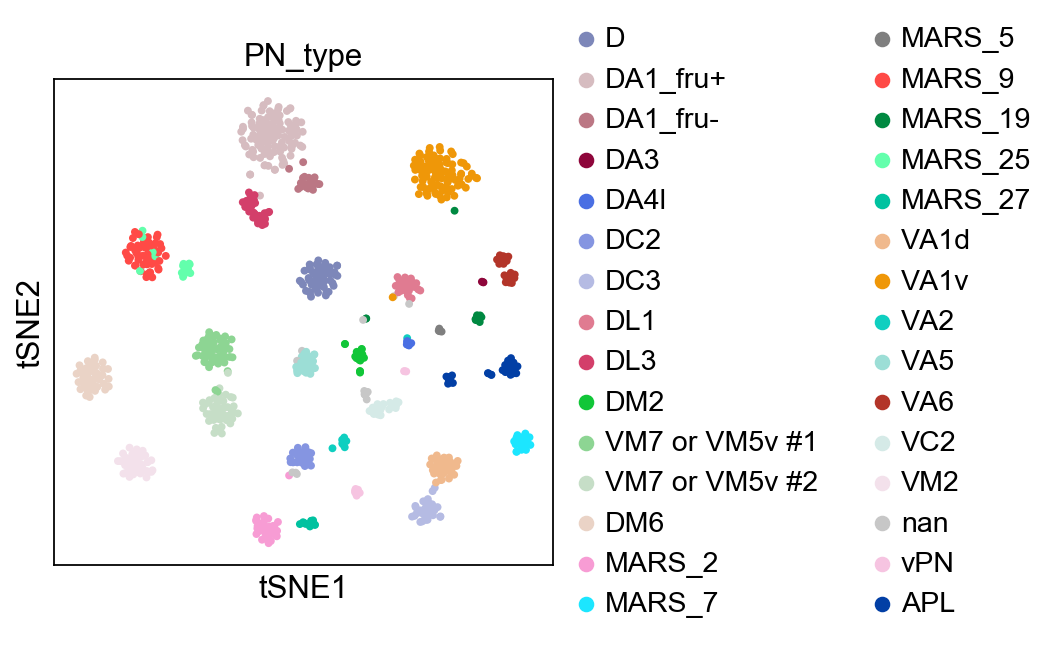

In [12]:
sc.settings.set_figure_params(dpi_save=600)
adata_24h.obsm['X_tsne'] = myTSNE.X_tsne
sc.pl.tsne(adata_24h, color='PN_type', size=(50,50))#,save='_24h_PN_type.pdf')

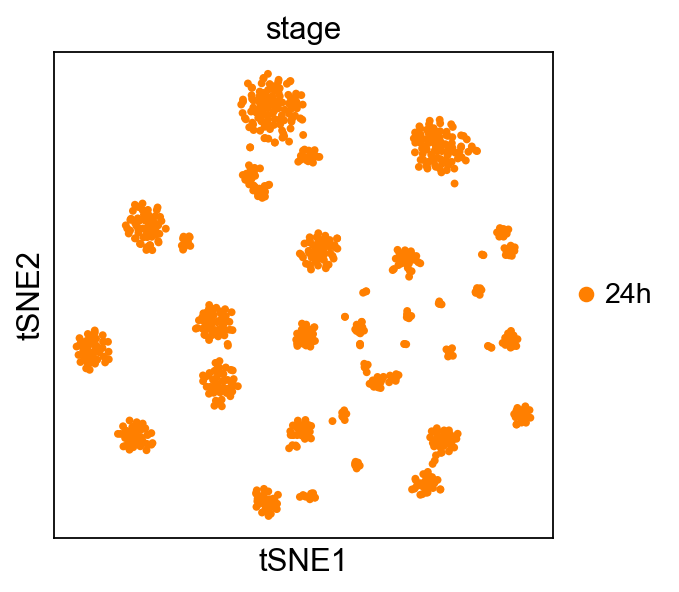

In [13]:
sc.settings.set_figure_params(dpi_save=600)
adata_24h.obsm['X_tsne'] = myTSNE.X_tsne
adata_24h.uns['stage_colors'] = ["#ff7f00"]
sc.pl.tsne(adata_24h, color='stage', size=(50,50))#,save='_24hICIM_stage.pdf')

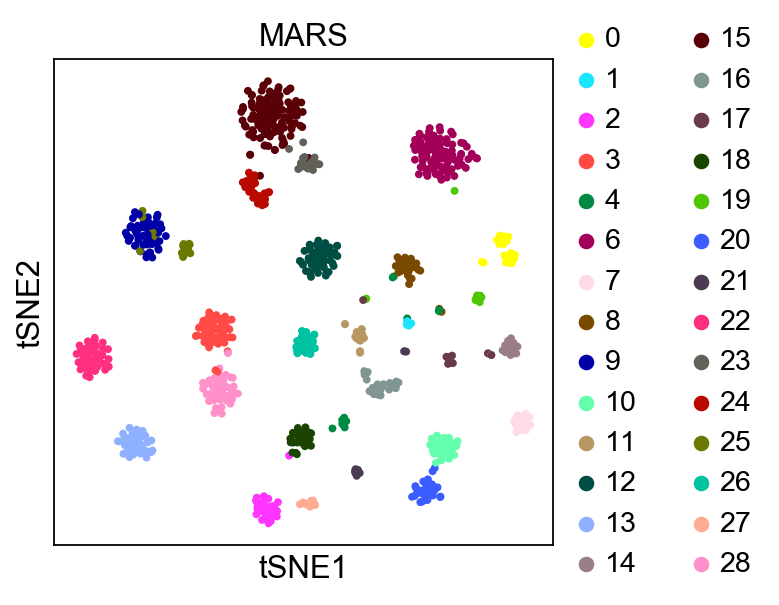

In [14]:
sc.pl.tsne(adata_24h, color='MARS', size=(50,50))#, save='_MARS.pdf')

In [15]:
cluster = hdbscan.HDBSCAN(min_cluster_size = 5, min_samples=3).fit(adata_24h.obsm['X_tsne'])
labels_HDBSCAN = cluster.labels_
print("Clusters", max(labels_HDBSCAN)+1)
adata_24h.obs['HDBSCAN'] = pd.Series([str(i) for i in labels_HDBSCAN], index=adata_24h.obs.index)

Clusters 31


In [16]:
adata_24h.uns['HDBSCAN_colors'][-1] = '#000000'

... storing 'HDBSCAN' as categorical


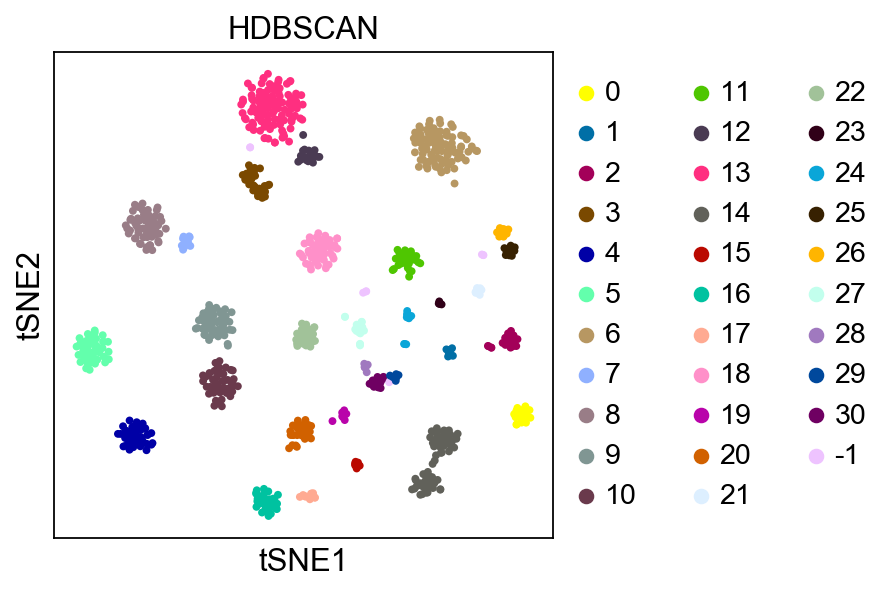

In [17]:
sc.pl.tsne(adata_24h, color=['HDBSCAN'], size=(50,50))#, save='_HDBSCAN_color.pdf')

In [18]:
# calculate pca
sc.pp.pca(adata_24h, svd_solver='arpack', use_highly_variable=True, random_state=1)
sc.pp.neighbors(adata_24h, n_neighbors=10, n_pcs=50,random_state=1)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


In [19]:
sc.tl.leiden(adata_24h)

running Leiden clustering
    finished: found 24 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


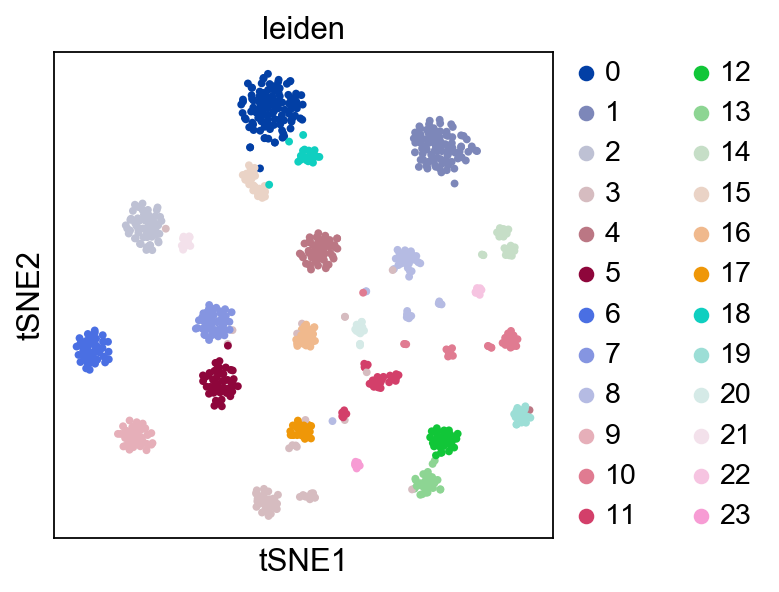

In [20]:
sc.pl.tsne(adata_24h, color=['leiden'], size=(50,50))#, save='_leiden_color.pdf')

top highly variable genes

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 40
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:03)


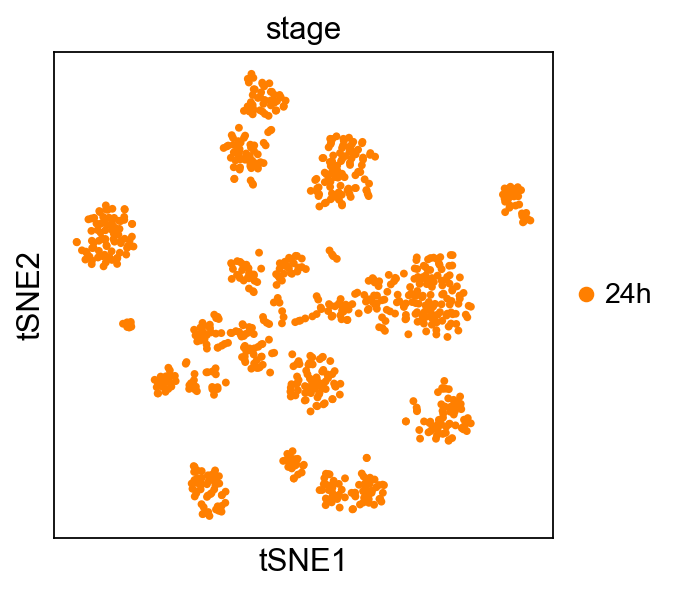

In [21]:
sc.pp.highly_variable_genes(adata_24h, n_top_genes=2000)
sc.pp.pca(adata_24h, svd_solver='arpack', use_highly_variable=True, random_state=1)
sc.tl.tsne(adata_24h, n_pcs=40, perplexity=10, learning_rate=250, 
           early_exaggeration=4.0, random_state=1)
sc.pl.tsne(adata_24h, color=['stage'], size=(50,50), save='_top2000_genes.pdf')

# 48h

In [22]:
adata_48h = adata[(adata.obs['genotype'] == 'GH146-GFP') & (adata.obs['stage'] == '48h')]
adata_48h

View of AnnData object with n_obs × n_vars = 888 × 17474 
    obs: 'batch', 'genotype', 'stage', 'n_counts', 'n_genes', 'PN_type', 'MARS', 'HDBSCAN', 'MARS_2way_matched', 'MARS_2way_matched_PN_type', 'lineage', '24h_HDBSCAN', 'matched_type_with_stage', 'mannually_matched'
    var: 'highly_variable'
    uns: '24h_HDBSCAN_colors', 'HDBSCAN_colors', 'MARS_2way_matched_PN_type_colors', 'MARS_2way_matched_colors', 'MARS_colors', 'PN_type_colors', 'mannually_matched_colors', 'stage_colors'
    obsm: 'X_tsne'

24h ICIM genes

In [23]:
adata_48h.var['highly_variable'] = adata_24h.var_names.isin(genes_24h_ICIM)

Trying to set attribute `.var` of view, copying.


In [24]:
df_ICIM = adata_48h.to_df()[genes_24h_ICIM].T
myTSNE = sct.TSNE(df_ICIM, adata_48h.to_df().T, df_libs)
myTSNE.calc_TSNE(perplexity=20, learning_rate=250, early_exaggeration=4.0, method="exact", random_state=1)

[t-SNE] Computed conditional probabilities for sample 888 / 888
[t-SNE] Mean sigma: 0.155833
[t-SNE] Iteration 50: error = 15.2952492, gradient norm = 0.0362036 (50 iterations in 1.578s)
[t-SNE] Iteration 100: error = 14.3107978, gradient norm = 0.0214682 (50 iterations in 1.529s)
[t-SNE] Iteration 150: error = 13.9848458, gradient norm = 0.0191319 (50 iterations in 1.502s)
[t-SNE] Iteration 200: error = 13.8619195, gradient norm = 0.0059497 (50 iterations in 1.522s)
[t-SNE] Iteration 250: error = 13.8121985, gradient norm = 0.0138216 (50 iterations in 1.497s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 13.812198
[t-SNE] Iteration 300: error = 0.7982465, gradient norm = 0.0010602 (50 iterations in 1.492s)
[t-SNE] Iteration 350: error = 0.7096384, gradient norm = 0.0005612 (50 iterations in 1.584s)
[t-SNE] Iteration 400: error = 0.6800258, gradient norm = 0.0002958 (50 iterations in 1.651s)
[t-SNE] Iteration 450: error = 0.6661931, gradient norm = 0.0002042 (50 i

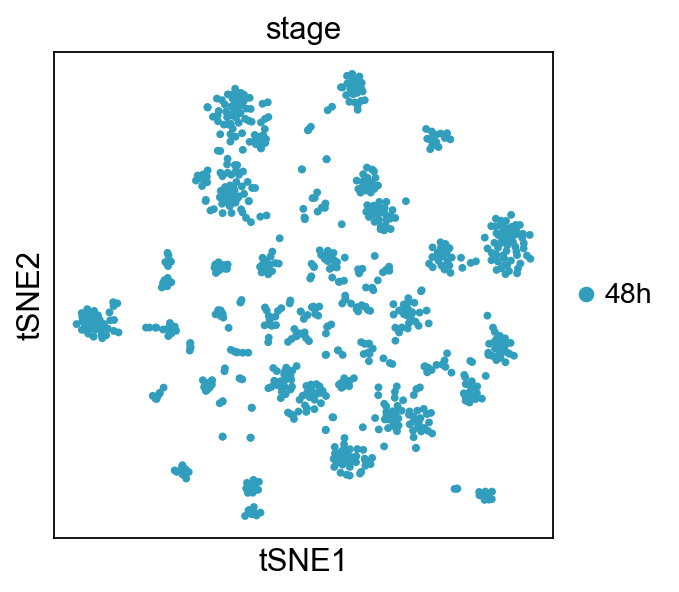

In [25]:
adata_48h.obsm['X_tsne'] = myTSNE.X_tsne
adata_48h.uns['stage_colors'] = ["#319ebd"]
sc.pl.tsne(adata_48h, color='stage', size=(50,50))#,save='_24hICIM_stage.pdf')

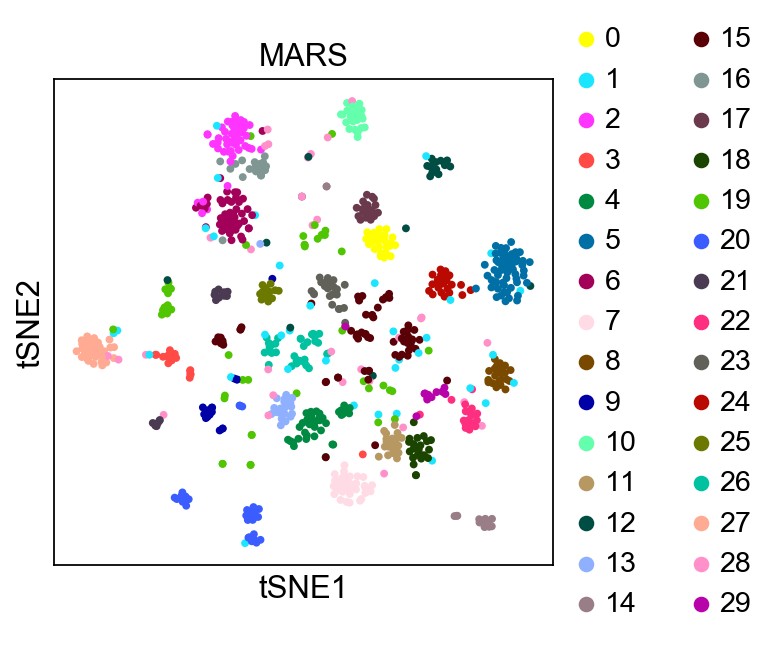

In [26]:
sc.pl.tsne(adata_48h, color='MARS', size=(50,50))#, save='_MARS.pdf')

In [27]:
cluster = hdbscan.HDBSCAN(min_cluster_size = 8, min_samples=8).fit(adata_48h.obsm['X_tsne'])
labels_HDBSCAN = cluster.labels_
print("Clusters", max(labels_HDBSCAN)+1)
adata_48h.obs['HDBSCAN'] = pd.Series([str(i) for i in labels_HDBSCAN], index=adata_48h.obs.index)

Clusters 33


In [35]:
# adata_48h.uns['HDBSCAN_colors'] = []
adata_48h.uns['HDBSCAN_colors'][-1] = '#000000'

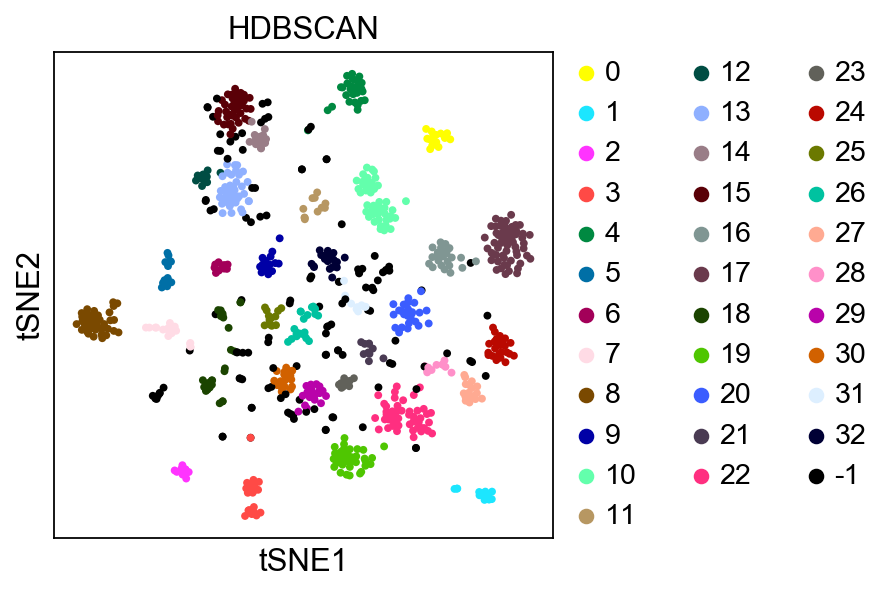

In [36]:
sc.pl.tsne(adata_48h, color=['HDBSCAN'], size=(50,50))#, save='_HDBSCAN_color.pdf')

In [37]:
# calculate pca
sc.pp.pca(adata_48h, svd_solver='arpack', use_highly_variable=True, random_state=1)
sc.pp.neighbors(adata_48h, n_neighbors=10, n_pcs=50,random_state=1)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [38]:
sc.tl.leiden(adata_48h,resolution=1.2)

running Leiden clustering
    finished: found 30 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


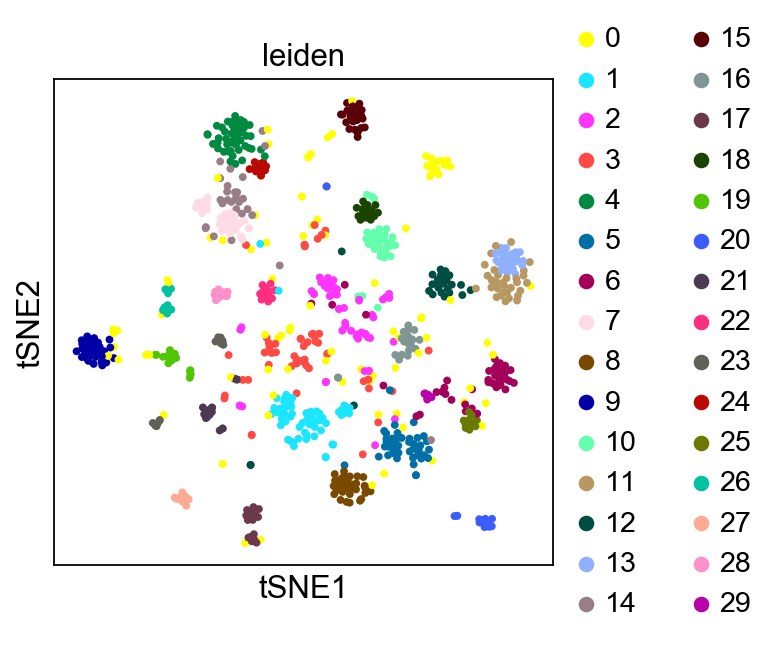

In [39]:
sc.pl.tsne(adata_48h, color=['leiden'], size=(50,50))#, save='_leiden_color.pdf')

48h ICIM

In [40]:
genes_48h_ICIM = []
with open("../data/ICIM_genes/48h_ICIM_685.txt") as f:
    for line in f:
        genes_48h_ICIM.append(line.rstrip())

print("Total ICIM genes at 24h= ", len(genes_48h_ICIM))

Total ICIM genes at 24h=  685


In [41]:
adata_48h.var['highly_variable'] = adata_48h.var_names.isin(genes_48h_ICIM)

In [42]:
df_ICIM = adata_48h.to_df()[genes_48h_ICIM].T
myTSNE = sct.TSNE(df_ICIM, adata_48h.to_df().T, df_libs)
myTSNE.calc_TSNE(perplexity=70, learning_rate=250, early_exaggeration=4.0, method="exact", random_state=1)

[t-SNE] Computed conditional probabilities for sample 888 / 888
[t-SNE] Mean sigma: 0.161170
[t-SNE] Iteration 50: error = 13.9910592, gradient norm = 0.0314361 (50 iterations in 2.048s)
[t-SNE] Iteration 100: error = 13.9663472, gradient norm = 0.0279464 (50 iterations in 1.673s)
[t-SNE] Iteration 150: error = 13.9743054, gradient norm = 0.0346611 (50 iterations in 1.486s)
[t-SNE] Iteration 200: error = 13.9624982, gradient norm = 0.0237426 (50 iterations in 1.507s)
[t-SNE] Iteration 250: error = 13.9632599, gradient norm = 0.0250149 (50 iterations in 1.539s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 13.963260
[t-SNE] Iteration 300: error = 0.9687905, gradient norm = 0.0010032 (50 iterations in 1.580s)
[t-SNE] Iteration 350: error = 0.9421888, gradient norm = 0.0001970 (50 iterations in 1.671s)
[t-SNE] Iteration 400: error = 0.9372287, gradient norm = 0.0000776 (50 iterations in 1.661s)
[t-SNE] Iteration 450: error = 0.9360203, gradient norm = 0.0000381 (50 i

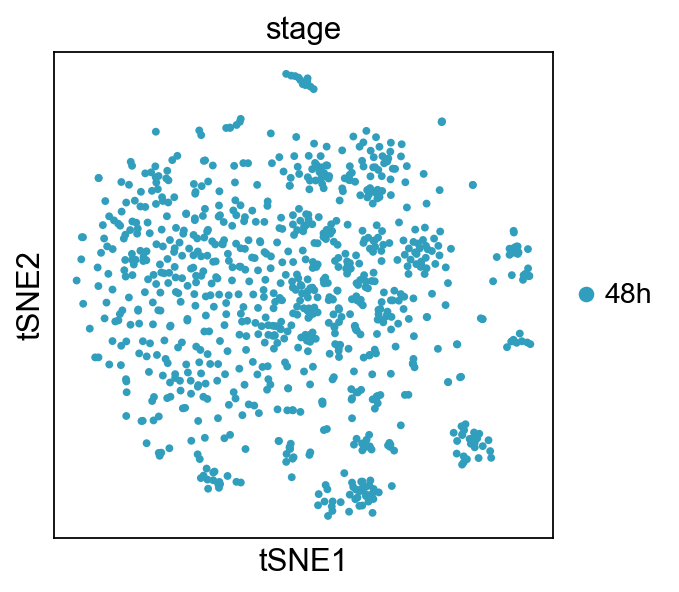

In [43]:
adata_48h.obsm['X_tsne'] = myTSNE.X_tsne
# adata_48h.uns['stage_colors'] = ["#319ebd"]
sc.pl.tsne(adata_48h, color='stage', size=(50,50))#,save='_48hICIM_stage.pdf')

top highly variable genes

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 40
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:03)


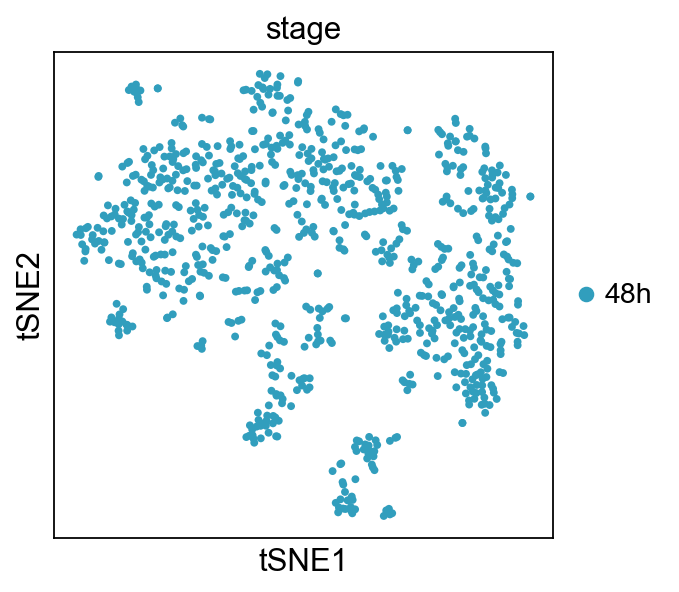

In [44]:
sc.pp.highly_variable_genes(adata_48h, n_top_genes=2000)
sc.pp.pca(adata_48h, svd_solver='arpack', use_highly_variable=True, random_state=1)
sc.tl.tsne(adata_48h, n_pcs=40, perplexity=10, learning_rate=250, 
           early_exaggeration=4.0, random_state=1)
sc.pl.tsne(adata_48h, color=['stage'], size=(50,50))#, save='_top2000_genes.pdf')

# adult

In [45]:
adata_adult = adata[(adata.obs['stage'] == 'adult')]
adata_adult

View of AnnData object with n_obs × n_vars = 641 × 17474 
    obs: 'batch', 'genotype', 'stage', 'n_counts', 'n_genes', 'PN_type', 'MARS', 'HDBSCAN', 'MARS_2way_matched', 'MARS_2way_matched_PN_type', 'lineage', '24h_HDBSCAN', 'matched_type_with_stage', 'mannually_matched'
    var: 'highly_variable'
    uns: '24h_HDBSCAN_colors', 'HDBSCAN_colors', 'MARS_2way_matched_PN_type_colors', 'MARS_2way_matched_colors', 'MARS_colors', 'PN_type_colors', 'mannually_matched_colors', 'stage_colors'
    obsm: 'X_tsne'

24h ICIM genes

In [46]:
adata_adult.var['highly_variable'] = adata_adult.var_names.isin(genes_24h_ICIM)

Trying to set attribute `.var` of view, copying.


In [47]:
df_ICIM = adata_adult.to_df()[genes_24h_ICIM].T
myTSNE = sct.TSNE(df_ICIM, adata_adult.to_df().T, df_libs)
myTSNE.calc_TSNE(perplexity=20, learning_rate=250, early_exaggeration=4.0, method="exact", random_state=1)

[t-SNE] Computed conditional probabilities for sample 641 / 641
[t-SNE] Mean sigma: 0.140661
[t-SNE] Iteration 50: error = 17.8484205, gradient norm = 0.0917021 (50 iterations in 0.903s)
[t-SNE] Iteration 100: error = 17.7952276, gradient norm = 0.0851986 (50 iterations in 0.887s)
[t-SNE] Iteration 150: error = 17.9028173, gradient norm = 0.0912283 (50 iterations in 0.882s)
[t-SNE] Iteration 200: error = 17.7600137, gradient norm = 0.0873225 (50 iterations in 0.869s)
[t-SNE] Iteration 250: error = 18.0486479, gradient norm = 0.0944013 (50 iterations in 0.864s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 18.048648
[t-SNE] Iteration 300: error = 1.2858148, gradient norm = 0.0017889 (50 iterations in 0.886s)
[t-SNE] Iteration 350: error = 1.2193771, gradient norm = 0.0005685 (50 iterations in 0.876s)
[t-SNE] Iteration 400: error = 1.1976571, gradient norm = 0.0002697 (50 iterations in 0.882s)
[t-SNE] Iteration 450: error = 1.1886207, gradient norm = 0.0001983 (50 i

In [48]:
adata.uns['stage_colors']

array(['#47de65', '#ff7f00', '#319ebd', '#2A3CA1'], dtype=object)

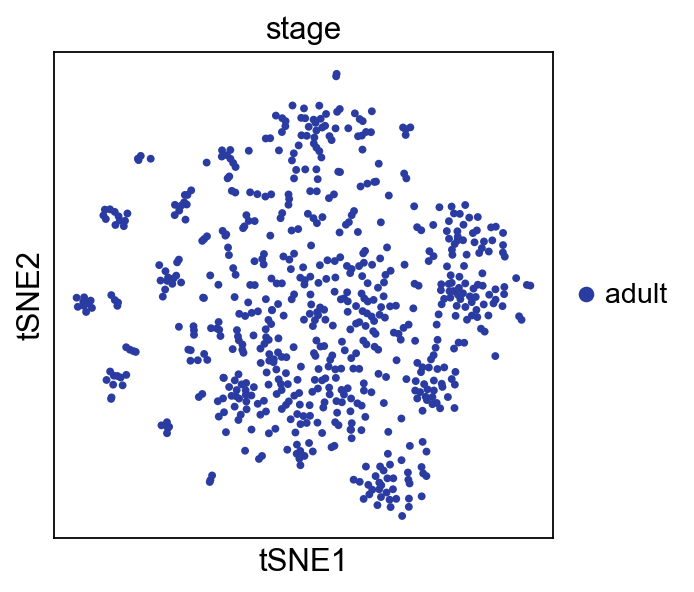

In [49]:
adata_adult.obsm['X_tsne'] = myTSNE.X_tsne
adata_adult.uns['stage_colors'] = ["#2A3CA1"]
sc.pl.tsne(adata_adult, color='stage', size=(50,50))#,save='_24hICIM_stage.pdf')

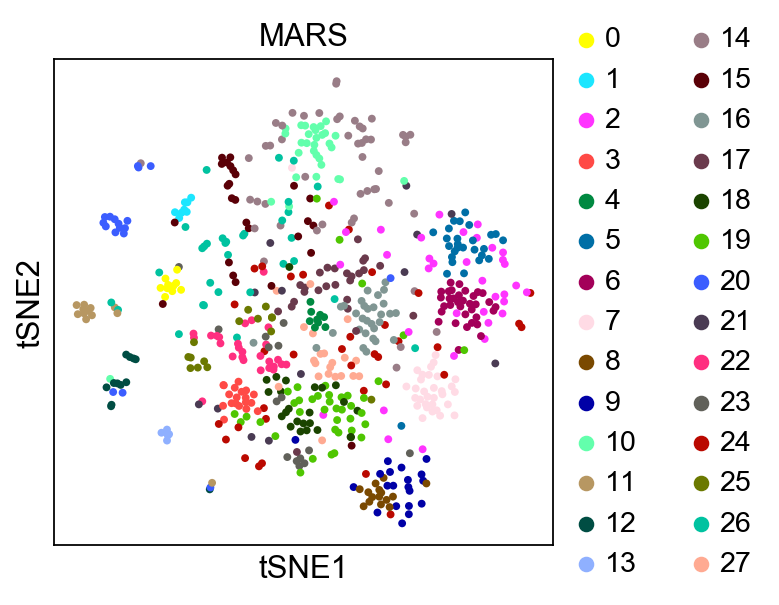

In [51]:
sc.pl.tsne(adata_adult, color='MARS', size=(50,50))#, save='_MARS.pdf')

In [52]:
cluster = hdbscan.HDBSCAN(min_cluster_size = 4, min_samples=4).fit(adata_adult.obsm['X_tsne'])
labels_HDBSCAN = cluster.labels_
print("Clusters", max(labels_HDBSCAN)+1)
adata_adult.obs['HDBSCAN'] = pd.Series([str(i) for i in labels_HDBSCAN], index=adata_adult.obs.index)

Clusters 31


In [54]:
adata_adult.uns['HDBSCAN_colors'][-1] = '#000000'

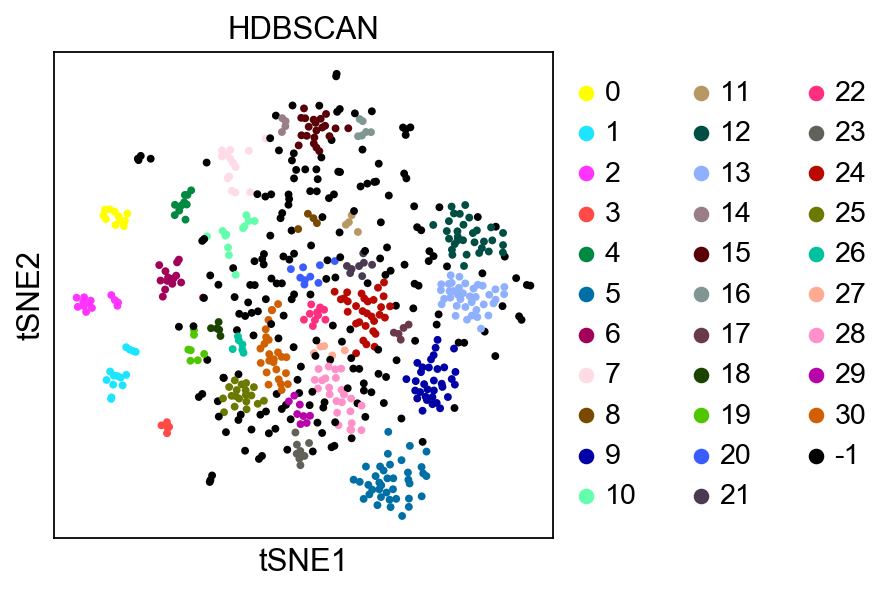

In [55]:
sc.pl.tsne(adata_adult, color=['HDBSCAN'], size=(50,50))#, save='_HDBSCAN_color.pdf')

In [56]:
# calculate pca
sc.pp.pca(adata_adult, svd_solver='arpack', use_highly_variable=True, random_state=1)
sc.pp.neighbors(adata_adult, n_neighbors=10, n_pcs=50,random_state=1)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [57]:
sc.tl.leiden(adata_adult,resolution=2)

running Leiden clustering
    finished: found 24 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


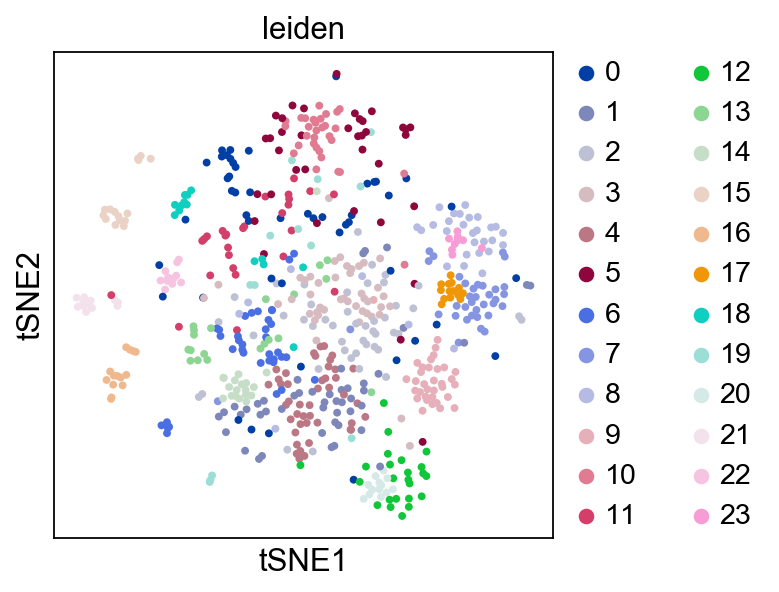

In [58]:
sc.pl.tsne(adata_adult, color=['leiden'], size=(50,50))#, save='_leiden_color.pdf')

adult ICIM

In [59]:
genes_adult_ICIM = []
with open("../data/ICIM_genes/adult_ICIM_385.txt") as f:
    for line in f:
        genes_adult_ICIM.append(line.rstrip())

print("Total ICIM genes at 24h= ", len(genes_adult_ICIM))

Total ICIM genes at 24h=  385


In [60]:
adata_adult.var['highly_variable'] = adata_adult.var_names.isin(genes_adult_ICIM)

In [61]:
df_ICIM = adata_adult.to_df()[genes_adult_ICIM].T
myTSNE = sct.TSNE(df_ICIM, adata_adult.to_df().T, df_libs)
myTSNE.calc_TSNE(perplexity=70, learning_rate=250, early_exaggeration=4.0, method="exact", random_state=1)

[t-SNE] Computed conditional probabilities for sample 641 / 641
[t-SNE] Mean sigma: 0.149047
[t-SNE] Iteration 50: error = 12.7337116, gradient norm = 0.1071230 (50 iterations in 0.897s)
[t-SNE] Iteration 100: error = 12.6835716, gradient norm = 0.1031389 (50 iterations in 0.898s)
[t-SNE] Iteration 150: error = 13.1768542, gradient norm = 0.0903081 (50 iterations in 0.855s)
[t-SNE] Iteration 200: error = 12.9959406, gradient norm = 0.0910874 (50 iterations in 0.917s)
[t-SNE] Iteration 250: error = 12.9321001, gradient norm = 0.0908140 (50 iterations in 0.888s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 12.932100
[t-SNE] Iteration 300: error = 0.9655274, gradient norm = 0.0013175 (50 iterations in 0.873s)
[t-SNE] Iteration 350: error = 0.9498554, gradient norm = 0.0006487 (50 iterations in 0.888s)
[t-SNE] Iteration 400: error = 0.9465475, gradient norm = 0.0003261 (50 iterations in 0.873s)
[t-SNE] Iteration 450: error = 0.9408951, gradient norm = 0.0003401 (50 i

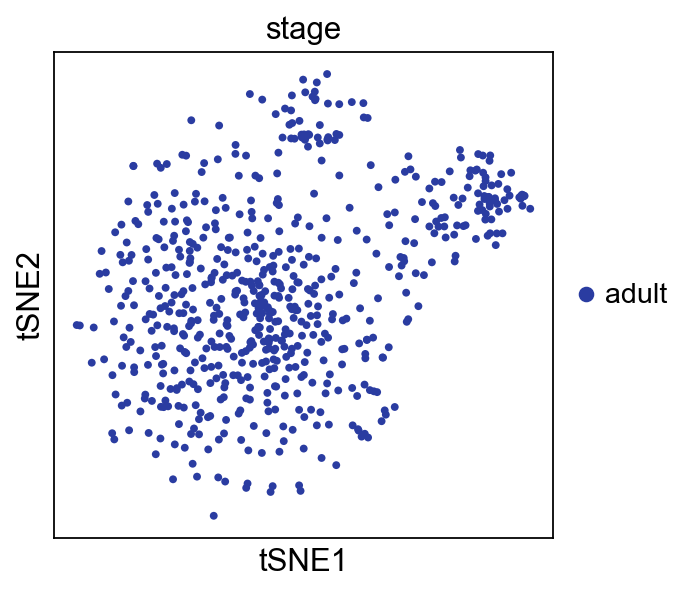

In [62]:
adata_adult.obsm['X_tsne'] = myTSNE.X_tsne
# adata_48h.uns['stage_colors'] = ["#319ebd"]
sc.pl.tsne(adata_adult, color='stage', size=(50,50))#,save='_adultICIM_stage.pdf')

In [63]:
cluster = hdbscan.HDBSCAN(min_cluster_size = 15, min_samples=15).fit(adata_adult.obsm['X_tsne'])
labels_HDBSCAN = cluster.labels_
print("Clusters", max(labels_HDBSCAN)+1)
adata_adult.obs['HDBSCAN'] = pd.Series([str(i) for i in labels_HDBSCAN], index=adata_adult.obs.index)

Clusters 3


In [70]:
# adata_adult.uns['HDBSCAN_colors'] = []
adata_adult.uns['HDBSCAN_colors'][-1] = '#000000'

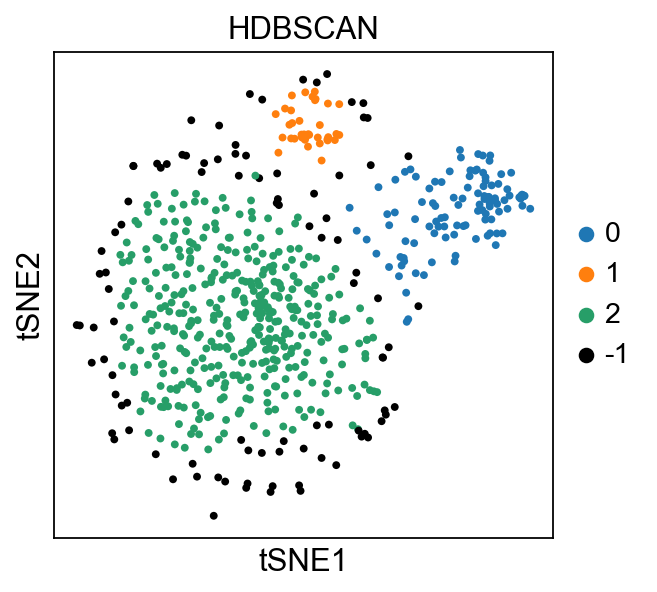

In [71]:
sc.pl.tsne(adata_adult, color=['HDBSCAN'], size=(50,50))#, save='_HDBSCAN_color.pdf')

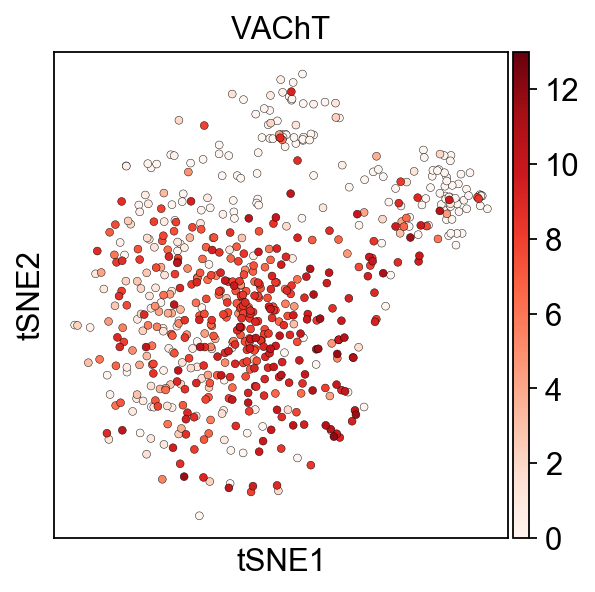

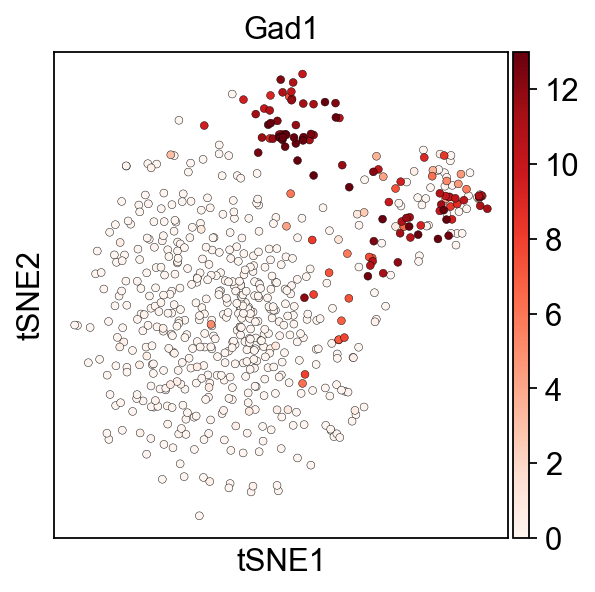

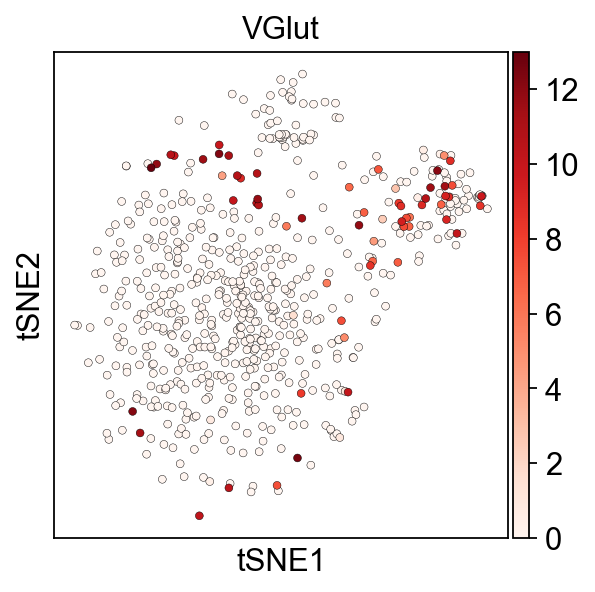

In [74]:
MyGenes = ['VAChT','Gad1','VGlut']
for gene in MyGenes:
    sc.pl.tsne(adata_adult, color=gene, size=(50,50), edgecolor="k", linewidths=0.2, vmax=13,
               color_map="Reds")#, save= '_'+gene+'.pdf')

top highly variable genes

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 40
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:02)


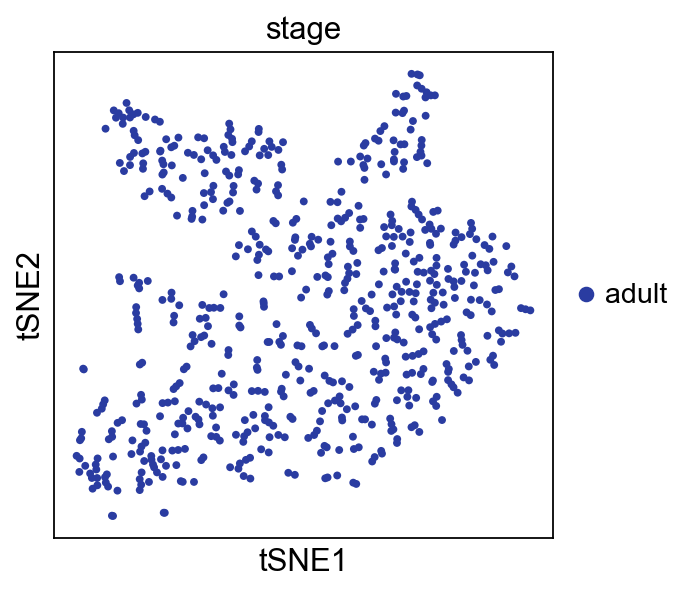

In [75]:
sc.pp.highly_variable_genes(adata_adult, n_top_genes=2000)
sc.pp.pca(adata_adult, svd_solver='arpack', use_highly_variable=True, random_state=1)
sc.tl.tsne(adata_adult, n_pcs=40, perplexity=10, learning_rate=250, 
           early_exaggeration=4.0, random_state=1)
sc.pl.tsne(adata_adult, color=['stage'], size=(50,50))#, save='_top2000_genes.pdf')

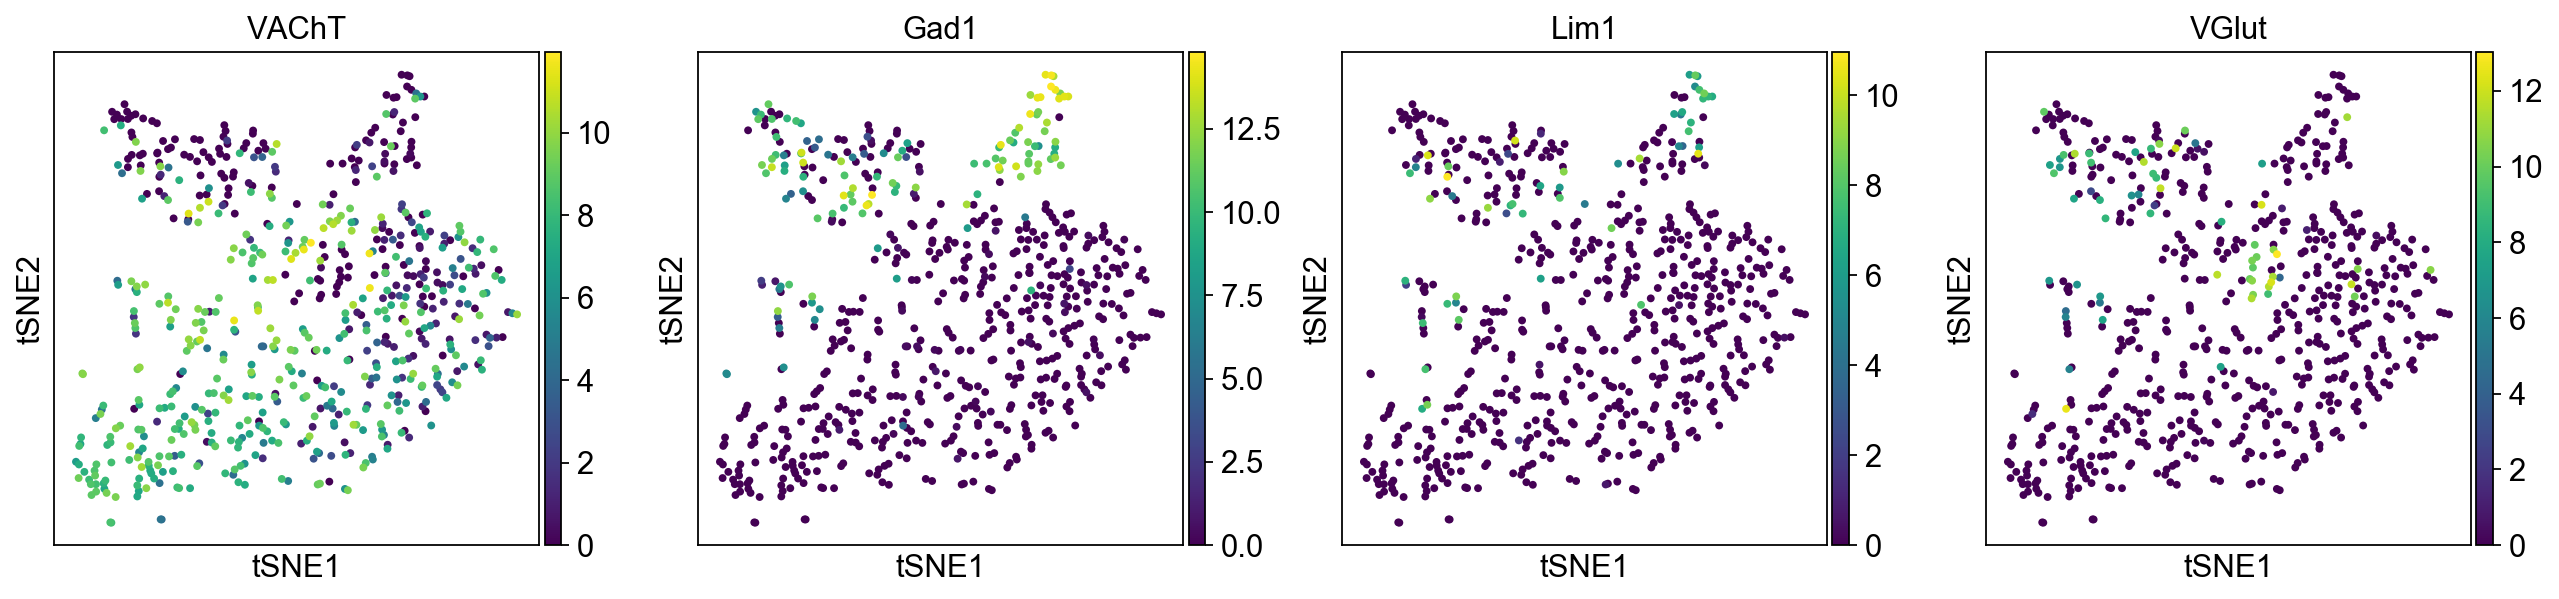

In [76]:
sc.pl.tsne(adata_adult, color=['VAChT','Gad1','Lim1','VGlut'], size=(50,50))

# 0h

In [77]:
adata_0h = adata[(adata.obs['stage'] == '0h')]
adata_0h

View of AnnData object with n_obs × n_vars = 1158 × 17474 
    obs: 'batch', 'genotype', 'stage', 'n_counts', 'n_genes', 'PN_type', 'MARS', 'HDBSCAN', 'MARS_2way_matched', 'MARS_2way_matched_PN_type', 'lineage', '24h_HDBSCAN', 'matched_type_with_stage', 'mannually_matched'
    var: 'highly_variable'
    uns: '24h_HDBSCAN_colors', 'HDBSCAN_colors', 'MARS_2way_matched_PN_type_colors', 'MARS_2way_matched_colors', 'MARS_colors', 'PN_type_colors', 'mannually_matched_colors', 'stage_colors'
    obsm: 'X_tsne'

24h ICIM genes

In [78]:
adata_0h.var['highly_variable'] = adata_0h.var_names.isin(genes_24h_ICIM)

Trying to set attribute `.var` of view, copying.


In [79]:
df_ICIM = adata_0h.to_df()[genes_24h_ICIM].T
myTSNE = sct.TSNE(df_ICIM, adata_0h.to_df().T, df_libs)
myTSNE.calc_TSNE(perplexity=50, learning_rate=250, early_exaggeration=4.0, method="exact", random_state=1)

[t-SNE] Computed conditional probabilities for sample 1000 / 1158
[t-SNE] Computed conditional probabilities for sample 1158 / 1158
[t-SNE] Mean sigma: 0.166304
[t-SNE] Iteration 50: error = 13.9811385, gradient norm = 0.0164533 (50 iterations in 2.311s)
[t-SNE] Iteration 100: error = 13.7699649, gradient norm = 0.0117642 (50 iterations in 2.372s)
[t-SNE] Iteration 150: error = 13.7626627, gradient norm = 0.0111256 (50 iterations in 2.383s)
[t-SNE] Iteration 200: error = 13.7608589, gradient norm = 0.0068113 (50 iterations in 2.373s)
[t-SNE] Iteration 250: error = 13.7609961, gradient norm = 0.0044530 (50 iterations in 2.557s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 13.760996
[t-SNE] Iteration 300: error = 0.9213765, gradient norm = 0.0005083 (50 iterations in 2.482s)
[t-SNE] Iteration 350: error = 0.8826939, gradient norm = 0.0002034 (50 iterations in 2.426s)
[t-SNE] Iteration 400: error = 0.8723242, gradient norm = 0.0001190 (50 iterations in 2.435s)
[t-SN

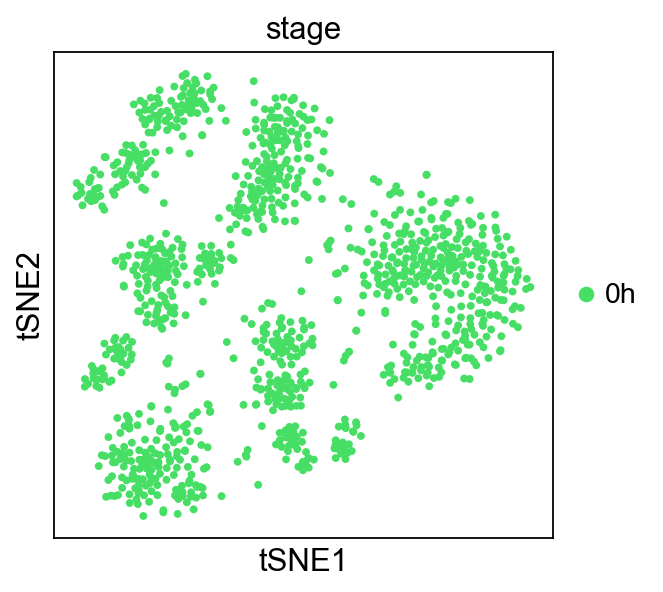

In [80]:
adata_0h.obsm['X_tsne'] = myTSNE.X_tsne
adata_0h.uns['stage_colors'] = ["#47de65"]
sc.pl.tsne(adata_0h, color='stage', size=(50,50))#,save='_24hICIM_stage.pdf')

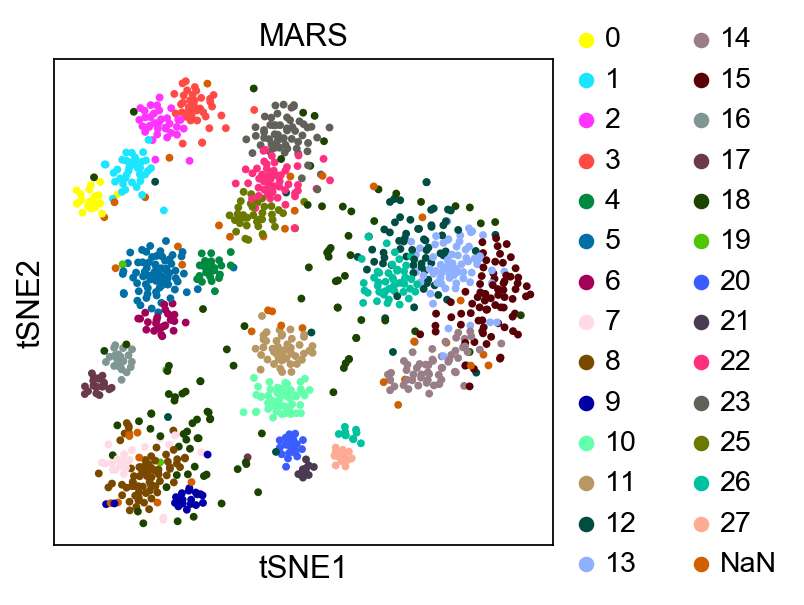

In [81]:
sc.pl.tsne(adata_0h, color='MARS', size=(50,50))#, save='_MARS.pdf')

In [82]:
cluster = hdbscan.HDBSCAN(min_cluster_size = 3, min_samples=3).fit(adata_0h.obsm['X_tsne'])
labels_HDBSCAN = cluster.labels_
print("Clusters", max(labels_HDBSCAN)+1)
adata_0h.obs['HDBSCAN'] = pd.Series([str(i) for i in labels_HDBSCAN], index=adata_0h.obs.index)

Clusters 18


In [86]:
adata_0h.uns['HDBSCAN_colors'][-1] = '#000000'
# adata_0h.uns['HDBSCAN_colors'] = []

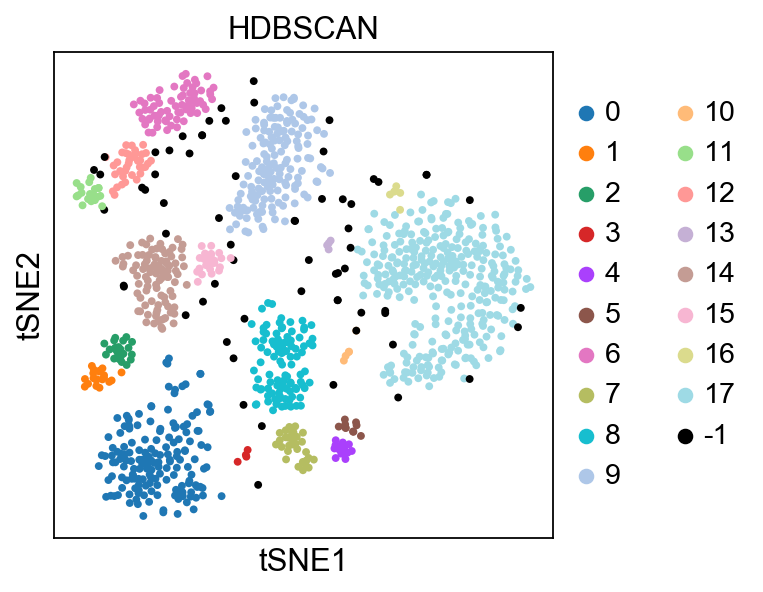

In [87]:
sc.pl.tsne(adata_0h, color=['HDBSCAN'], size=(50,50))#, save='_HDBSCAN_color.pdf')

In [88]:
# calculate pca
sc.pp.pca(adata_0h, svd_solver='arpack', use_highly_variable=True, random_state=1)
sc.pp.neighbors(adata_0h, n_neighbors=10, n_pcs=50,random_state=1)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [89]:
sc.tl.leiden(adata_0h,resolution=2)

running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


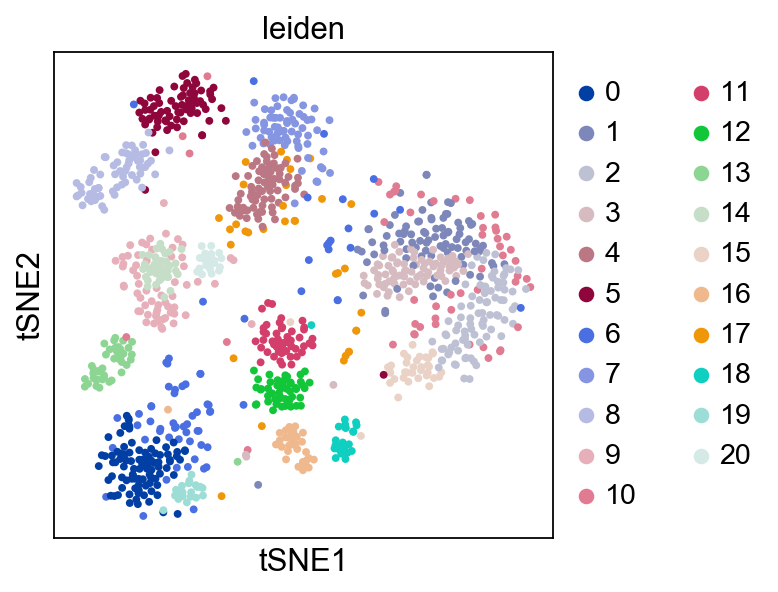

In [90]:
sc.pl.tsne(adata_0h, color=['leiden'], size=(50,50))#, save='_leiden_color.pdf')

0h ICIM

In [91]:
genes_0h_ICIM = []
with open("../data/ICIM_genes/0h_ICIM_333.txt") as f:
    for line in f:
        genes_0h_ICIM.append(line.rstrip())

print("Total ICIM genes at 0h= ", len(genes_0h_ICIM))

Total ICIM genes at 0h=  333


In [92]:
adata_0h.var['highly_variable'] = adata_0h.var_names.isin(genes_0h_ICIM)

In [97]:
df_ICIM = adata_0h.to_df()[genes_0h_ICIM].T
myTSNE = sct.TSNE(df_ICIM, adata_0h.to_df().T, df_libs)
myTSNE.calc_TSNE(perplexity=50, learning_rate=250, early_exaggeration=4.0, method="exact", random_state=1)

[t-SNE] Computed conditional probabilities for sample 1000 / 1094
[t-SNE] Computed conditional probabilities for sample 1094 / 1094
[t-SNE] Mean sigma: 0.151599
[t-SNE] Iteration 50: error = 15.3140878, gradient norm = 0.0427990 (50 iterations in 2.080s)
[t-SNE] Iteration 100: error = 15.2518649, gradient norm = 0.0266108 (50 iterations in 2.120s)
[t-SNE] Iteration 150: error = 15.2428529, gradient norm = 0.0287938 (50 iterations in 2.145s)
[t-SNE] Iteration 200: error = 15.2055468, gradient norm = 0.0315416 (50 iterations in 2.141s)
[t-SNE] Iteration 250: error = 15.2342554, gradient norm = 0.0375589 (50 iterations in 2.238s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 15.234255
[t-SNE] Iteration 300: error = 1.3066864, gradient norm = 0.0005736 (50 iterations in 2.366s)
[t-SNE] Iteration 350: error = 1.2758186, gradient norm = 0.0002067 (50 iterations in 2.504s)
[t-SNE] Iteration 400: error = 1.2679785, gradient norm = 0.0001798 (50 iterations in 2.519s)
[t-SN

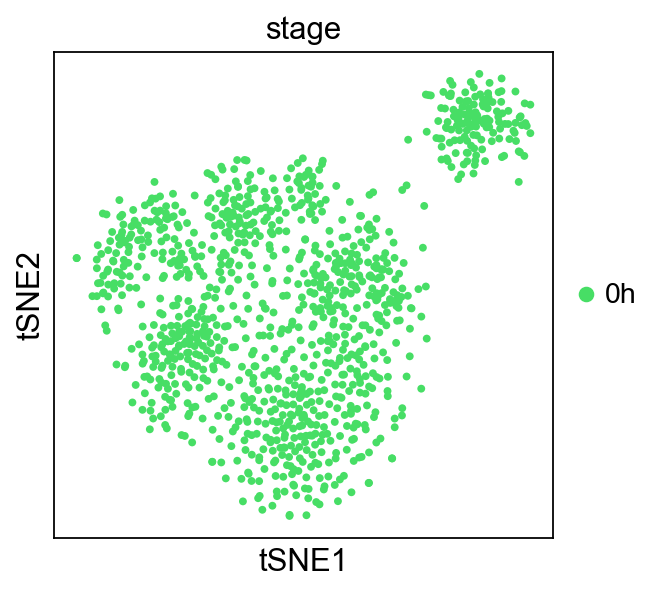

In [98]:
adata_0h.obsm['X_tsne'] = myTSNE.X_tsne
# adata_48h.uns['stage_colors'] = ["#319ebd"]
sc.pl.tsne(adata_0h, color='stage', size=(50,50))#,save='_0hICIM_stage.pdf')

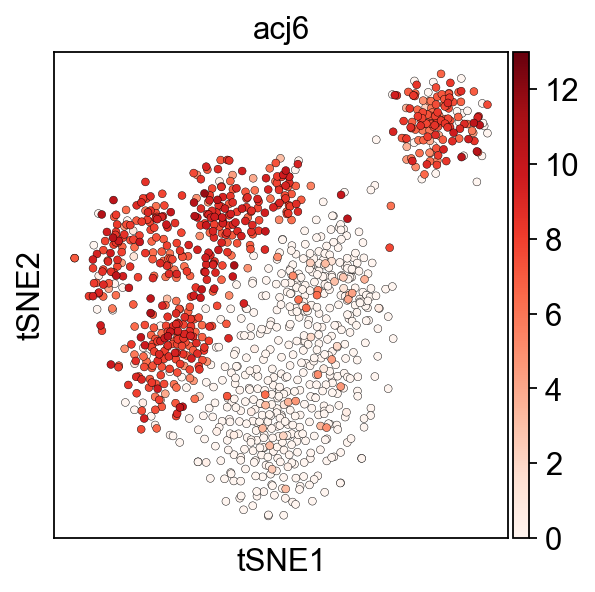

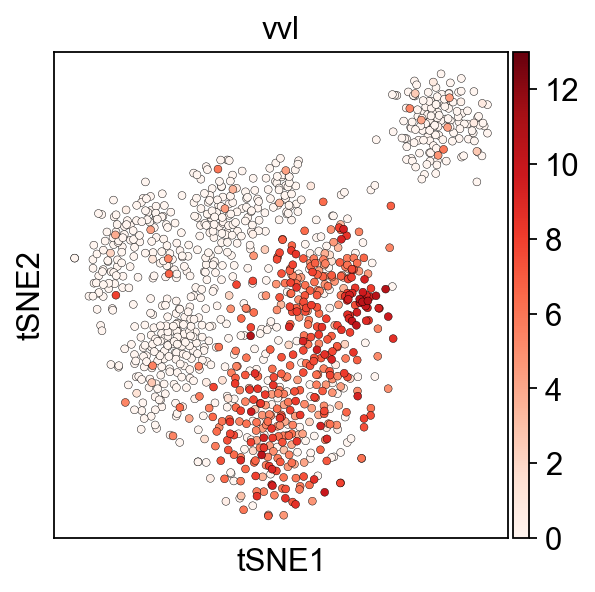

In [99]:
MyGenes = ['acj6','vvl']
for gene in MyGenes:
    sc.pl.tsne(adata_0h, color=gene, size=(50,50), edgecolor="k", linewidths=0.2, vmax=13,
               color_map="Reds")#, save= '_'+gene+'.pdf')

top highly variable genes

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 40
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:05)


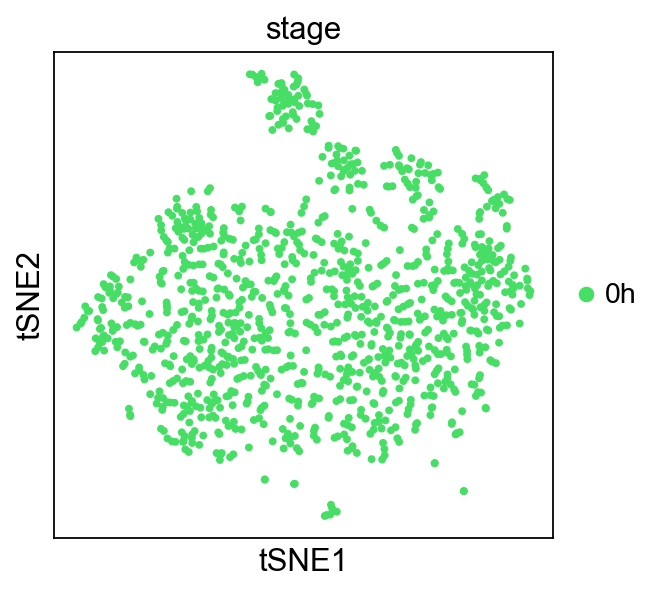

In [100]:
sc.pp.highly_variable_genes(adata_0h, n_top_genes=2000)
sc.pp.pca(adata_0h, svd_solver='arpack', use_highly_variable=True, random_state=1)
sc.tl.tsne(adata_0h, n_pcs=40, perplexity=10, learning_rate=250, 
           early_exaggeration=4.0, random_state=1)
sc.pl.tsne(adata_0h, color=['stage'], size=(50,50))#, save='_top2000_genes.pdf')

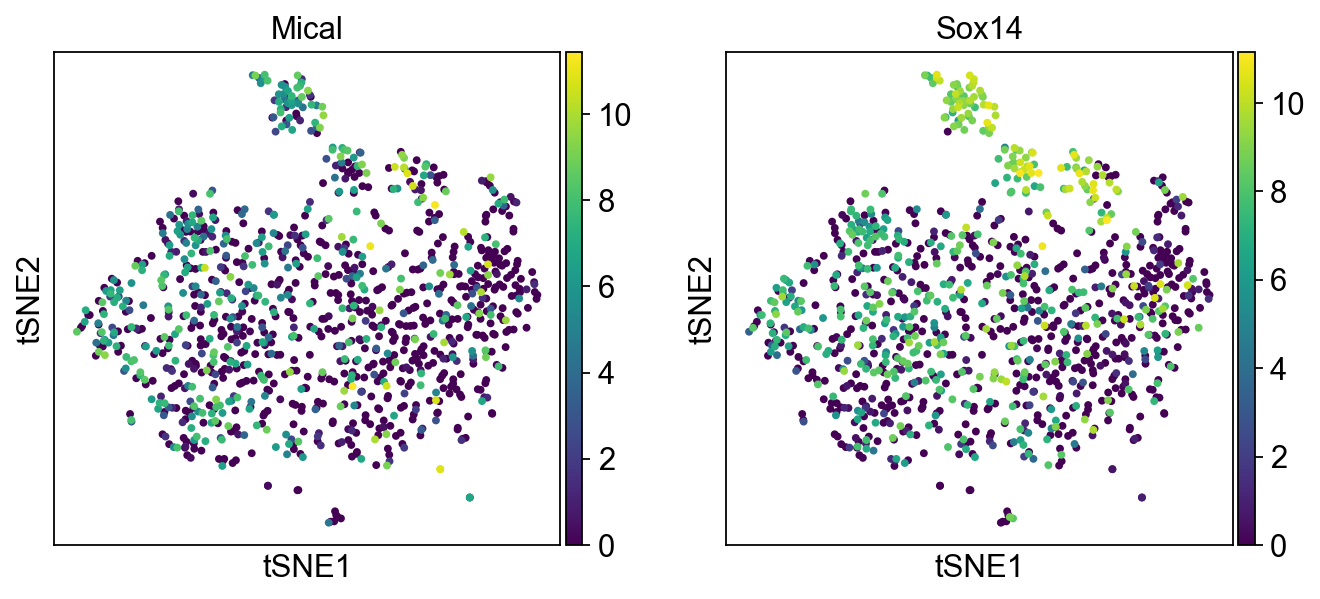

In [101]:
sc.pl.tsne(adata_0h, color=['Mical','Sox14'], size=(50,50))

In [102]:
adata_0h.obsm['X_tsne'] = myTSNE.X_tsne

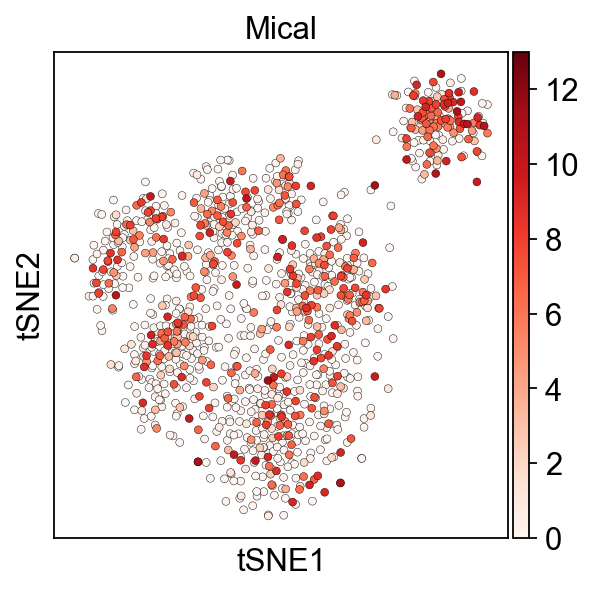

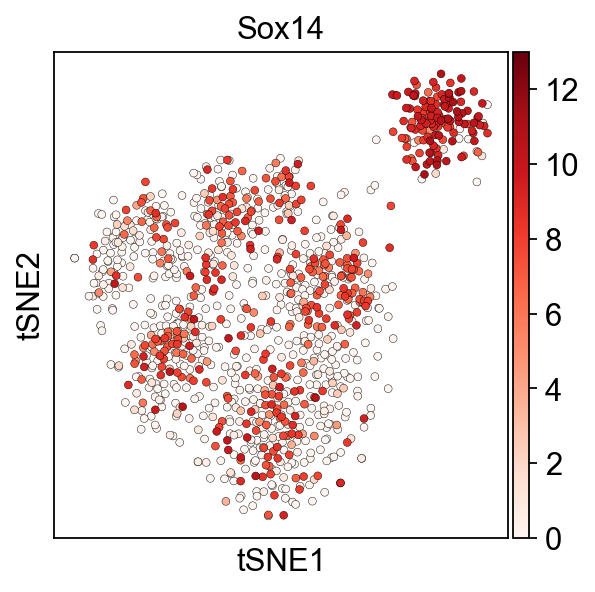

In [103]:
MyGenes = ['Mical','Sox14']
for gene in MyGenes:
    sc.pl.tsne(adata_0h, color=gene, size=(50,50), edgecolor="k", linewidths=0.2, vmax=13,
               color_map="Reds", save= '_'+gene+'.pdf')

In [104]:
cluster = hdbscan.HDBSCAN(min_cluster_size = 5, min_samples=3).fit(adata_0h.obsm['X_tsne'])
labels_HDBSCAN = cluster.labels_
print("Clusters", max(labels_HDBSCAN)+1)
adata_0h.obs['HDBSCAN'] = pd.Series([str(i) for i in labels_HDBSCAN], index=adata_0h.obs.index)
adata_0h.uns['HDBSCAN_colors'] = ['#ff8c69','#10a5f5']

Clusters 2


... storing 'HDBSCAN' as categorical


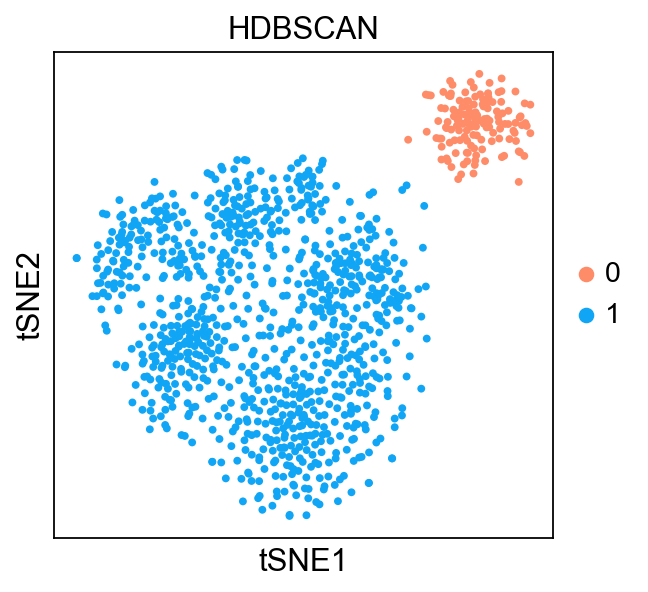

In [105]:
sc.pl.tsne(adata_0h, color=['HDBSCAN'], size=(50,50))#, save='_0h_ICIM_HDBSCAN.pdf')

In [106]:
adata_0h.obs

batch      genotype stage   n_counts  n_genes   PN_type  \
PN_0h_VTGAL4_P1_A12     0  VT033006-GFP    0h  7028534.0   5076.0       VA6   
PN_0h_VTGAL4_P1_A15     0  VT033006-GFP    0h  6937168.0   3751.0  DA1_fru+   
PN_0h_VTGAL4_P1_A18     0  VT033006-GFP    0h  3927134.0   1320.0       nan   
PN_0h_VTGAL4_P1_A19     0  VT033006-GFP    0h  2151156.0   2448.0       DC2   
PN_0h_VTGAL4_P1_A1      0  VT033006-GFP    0h  1619574.0   2016.0       nan   
...                   ...           ...   ...        ...      ...       ...   
PN_0h_VT_P8_A91         0  VT033006-GFP    0h   323611.0   4213.0    MARS_5   
PN_0h_VT_P8_A92         0  VT033006-GFP    0h   302290.0   3572.0         D   
PN_0h_VT_P8_A94         0  VT033006-GFP    0h   194137.0   4870.0       VA6   
PN_0h_VT_P8_A96         0  VT033006-GFP    0h   162868.0   2542.0         D   
PN_0h_VT_P8_A99         0  VT033006-GFP    0h   225260.0   4826.0       VA6   

                    MARS HDBSCAN MARS_2way_matched MARS_2way_matched_PN_type  \
PN_0h_VTGAL4_P1_A12    8       0                 0                       VA6   
PN_0h_VTGAL4_P1_A15   26       1                15                  DA1_fru+   
PN_0h_VTGAL4_P1_A18   18       0               nan                       nan   
PN_0h_VTGAL4_P1_A19    6       1                18                       DC2   
PN_0h_VTGAL4_P1_A1    14       1               nan                       nan   
...                  ...     ...               ...                       ...   
PN_0h_VT_P8_A91       16       1               nan                       nan   
PN_0h_VT_P8_A92        5       1                12                         D   
PN_0h_VT_P8_A94        8       0                 0                       VA6   
PN_0h_VT_P8_A96        5       1                12                         D   
PN_0h_VT_P8_A99        8       0                 0                       VA6   

                    lineage 24h_HDBSCAN matched_type_with_stage  \
PN_0h_VTGAL4_P1_A12    adPN          na                 VA6: 0h   
PN_0h_VTGAL4_P1_A15     lPN          na            DA1_fru+: 0h   
PN_0h_VTGAL4_P1_A18    adPN          na                 nan: 0h   
PN_0h_VTGAL4_P1_A19    adPN          na                 DC2: 0h   
PN_0h_VTGAL4_P1_A1      lPN          na                 nan: 0h   
...                     ...         ...                     ...   
PN_0h_VT_P8_A91        adPN          na              MARS_5: 0h   
PN_0h_VT_P8_A92        adPN          na                   D: 0h   
PN_0h_VT_P8_A94        adPN          na                 VA6: 0h   
PN_0h_VT_P8_A96        adPN          na                   D: 0h   
PN_0h_VT_P8_A99        adPN          na                 VA6: 0h   

                    mannually_matched leiden  
PN_0h_VTGAL4_P1_A12               VA6      0  
PN_0h_VTGAL4_P1_A15               nan      3  
PN_0h_VTGAL4_P1_A18               nan      6  
PN_0h_VTGAL4_P1_A19               nan      9  
PN_0h_VTGAL4_P1_A1                nan      2  
...                               ...    ...  
PN_0h_VT_P8_A91                MARS_5     13  
PN_0h_VT_P8_A92                     D     14  
PN_0h_VT_P8_A94                   VA6      0  
PN_0h_VT_P8_A96                     D     14  
PN_0h_VT_P8_A99                   VA6      0  

[1094 rows x 15 columns]

In [107]:
adata_0h.obs['emb_PN_decoded'] = ''

In [108]:
adata_0h.obs['emb_PN_decoded'][np.in1d(adata_0h.obs['PN_type'], ['VA6'])] = 'VA6'
adata_0h.obs['emb_PN_decoded'][np.in1d(adata_0h.obs['PN_type'], ['DA4l'])] = 'DA4l'

In [109]:
adata_0h.uns['emb_PN_decoded_colors'] = ['#b3b3b3', '#ff7f0e', '#279e68']

... storing 'emb_PN_decoded' as categorical


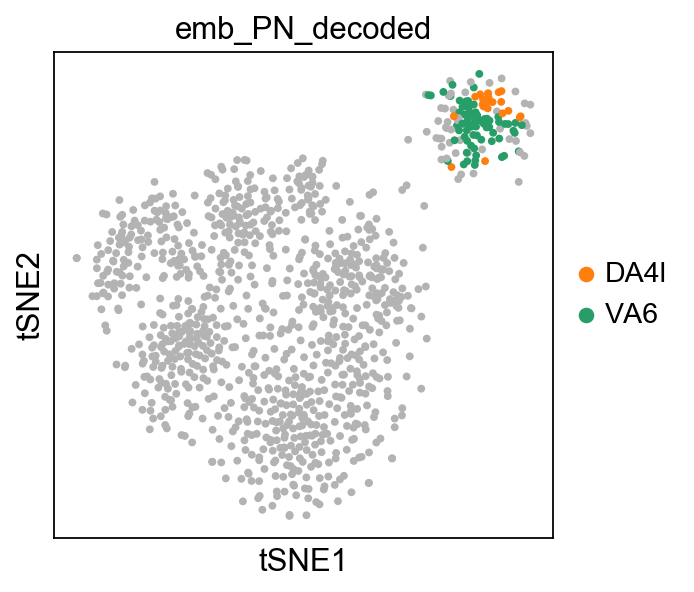

In [110]:
sc.pl.tsne(adata_0h, color=['emb_PN_decoded'], size=(50,50))#, save='_decoded_emb.pdf')